In [1]:
import tensorflow as tf
sess = tf.Session()
from keras import backend as K
K.set_session(sess)
from osgeo import ogr, osr

import numpy as np 

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os

import rasterio
from rasterio.transform import from_origin
from tqdm import tnrange, tqdm_notebook
from sentinelhub import WmsRequest, WcsRequest, MimeType, CRS, BBox, constants
from scipy.ndimage import median_filter
from skimage.transform import resize
import pandas as pd

Using TensorFlow backend.


In [540]:
model = 'proposed'
if model == "proposed":
    model = "../../models/april-10/88-69-5/"
    new_saver = tf.train.import_meta_graph(model + "model.meta")
    new_saver.restore(sess, tf.train.latest_checkpoint(model))

    for i in range(50):
        try:
            fm = tf.get_default_graph().get_tensor_by_name("conv2d_{}/Sigmoid:0".format(i))
        except Exception:
            pass
    #logits = tf.get_default_graph().get_tensor_by_name("conv2d_11/Sigmoid:0")
    inp = tf.get_default_graph().get_tensor_by_name("Placeholder:0")
    labels = tf.get_default_graph().get_tensor_by_name("Placeholder_2:0")
    rmax = tf.get_default_graph().get_tensor_by_name("Placeholder_4:0")
    rmin = tf.get_default_graph().get_tensor_by_name("Placeholder_5:0")
    length = tf.get_default_graph().get_tensor_by_name("Placeholder_1:0")
    dmax = tf.get_default_graph().get_tensor_by_name("Placeholder_6:0")
if model == 'unet':
    model = "../../models/unet-resnet/new/34-65-9/"
    new_saver = tf.train.import_meta_graph(model + "model.meta")
    new_saver.restore(sess, tf.train.latest_checkpoint(model))
    for i in range(50):
            try:
                fm = tf.get_default_graph().get_tensor_by_name("conv2d_{}/Sigmoid:0".format(i))
            except Exception:
                pass

    inp = tf.get_default_graph().get_tensor_by_name("Placeholder:0")
    rmax = tf.get_default_graph().get_tensor_by_name("Placeholder_4:0")
    rmin = tf.get_default_graph().get_tensor_by_name("Placeholder_5:0")
    dmax = tf.get_default_graph().get_tensor_by_name("Placeholder_6:0")
    

INFO:tensorflow:Restoring parameters from ../../models/april-10/88-69-5/model


In [744]:
# December 10-11 model, validated-size, filled in by train-l2a-dec
max_all = [0.20792677521705638,
 0.2990041905641556,
 0.4360648360848427,
 0.5161105132102968,
 0.4825860628485681,
 0.4943232241272928,
 0.5178957056999209,
 0.5291672283411026,
 0.6659183305501939,
 0.6092100739479065,
 0.37346625328063965,
 0.7162704998254776,
 0.40363759160041823,
 0.6478493613004686,
 0.8438000082969666,
 0.15365000069141388]

min_all = [0.01872335869818926,
 0.03467957343906164,
 0.021185510214418172,
 0.08898216009140014,
 0.052402322441339494,
 0.07628638863563539,
 0.083824477866292,
 0.08768215030431747,
 0.05718051139265299,
 0.0372315139323473,
 0.0,
 0.007564654648303981,
 -0.019136652257293465,
 0.0064204379683360435,
 0.006225000135600567,
 4.999999873689376e-05]

clipping_params = {
    'rmax': rmax,
    'rmin': rmin,
    'dmax': dmax
}

def load_file(file):
    plot_id = int(data['PL_PLOTID'][data['PLOT_ID'] == file].unique())
    x = np.load("../../data/drylands/s2/" + str(file) + ".npy")

    filtered = median_filter(x[0, :, :, 10], size = 5)
    filtered = np.reshape(filtered, (8, 2, 8, 2))
    filtered = np.mean(filtered, axis = (1, 3))
    filtered = resize(filtered, (16, 16), 0)
    x[:, :, :, 10] = np.stack([filtered] * 24)
    
    s1 = np.load("../../data/drylands/s1/" + str(file) + ".npy")
    x = np.concatenate([x, s1], axis = -1)
    x = np.delete(x, 14, -1)
    
    for band in range(0, x.shape[-1]):
        mins = min_all[band]
        maxs = max_all[band]
        x[:, :, :, band] = np.clip(x[:, :, :, band], mins, maxs)
        midrange = (maxs + mins) / 2
        rng = maxs - mins
        standardized = (x[:, :, :,band] - midrange) / (rng / 2)
        x[:, :, :, band] = standardized
        
    return x, plot_id
    
def predict_array(x, plot_id):
    lengths = np.tile(np.array(24), (1, 1))
    batch_pred= sess.run([fm], feed_dict={inp: x[np.newaxis, :, :, :, :],
                                      length: lengths,
                                      clipping_params['rmax']: 5,
                                      clipping_params['rmin']: 0,
                                      clipping_params['dmax']: 3,
                                      })
    batch_pred = np.array(batch_pred).reshape((14, 14))

    batch_pred[np.where(batch_pred >= 0.5)] = 1.
    batch_pred[np.where(batch_pred < 0.5)] = 0.
    sub = df[df['PLOT_ID'] == plot_id]
    ys = np.array(sub['tree_cover'])
    country = sub['Country']

    op1 = np.sum(batch_pred[3:10, 4:11]) / 49
    op2 = np.sum(batch_pred[3:10, 3:10]) / 49
    op3 = np.sum(batch_pred[4:11, 3:10]) / 49
    op4 = np.sum(batch_pred[4:11, 4:11]) / 49

    ops = [op1, op2, op3, op4]
    pred = np.mean(ops)
    return pred, ys, country

def predict_unet(x, plot_id):
    x = np.mean(x, axis = 0)
    batch_pred= sess.run([fm], feed_dict={inp: x[np.newaxis, :, :, :],
                                      clipping_params['rmax']: 5,
                                      clipping_params['rmin']: 0,
                                      clipping_params['dmax']: 3,
                                      })
    batch_pred = np.array(batch_pred).reshape((14, 14))

    batch_pred[np.where(batch_pred >= 0.5)] = 1.
    batch_pred[np.where(batch_pred < 0.5)] = 0.
    sub = df[df['PLOT_ID'] == plot_id]
    ys = np.array(sub['tree_cover'])
    country = sub['Country']

    op1 = np.sum(batch_pred[3:10, 4:11]) / 49
    op2 = np.sum(batch_pred[3:10, 3:10]) / 49
    op3 = np.sum(batch_pred[4:11, 3:10]) / 49
    op4 = np.sum(batch_pred[4:11, 4:11]) / 49

    ops = [op1, op2, op3, op4]
    pred = np.mean(ops)
    return pred, ys, country

def predict_rf(x, plot_id):
    x = np.mean(x, axis = 0)
    x = x[1:-1, 1:-1, :]
    x = np.reshape(x, (x.shape[0]*x.shape[1], x.shape[-1]))


    preds = clf.predict(x)

    preds[np.where(preds >= 0.43)] = 1.
    preds[np.where(preds < 0.43)] = 0.
    preds = preds.reshape((14, 14))
    sub = df[df['PLOT_ID'] == plot_id]
    ys = np.array(sub['tree_cover'])
    country = sub['Country']

    op1 = np.sum(preds[3:10, 4:11]) / 49
    #op2 = np.sum(preds[3:10, 3:10]) / 49
    #op3 = np.sum(preds[4:11, 3:10]) / 49
    #op4 = np.sum(preds[4:11, 4:11]) / 49

    #ops = [op1, op2, op3, op4]
    #ops_diff = np.array([abs(x - ys) for x in ops]).flatten()
    #pred = np.array(ops[np.argmin(np.array(ops_diff))])
    #pred = min(possible_values, key=lambda x:abs(x-pred))
    #pred = np.mean(ops)
    pred = op1
    
    return pred, ys, country

# Load Bastin et al. stratified samples

In [542]:
df = pd.read_csv("../../data/latlongs/stratified.csv")
df['PLOT_ID'] = range(0, len(df))
df = df.reset_index()
df = df.drop("Unnamed: 0", axis = 1)
df1 = pd.read_csv("../../data/latlongs/stratified_new.csv")
df1['PLOT_ID'] = range(3000, 3000+len(df1))
df1 = df1.reset_index()
df1 = df1.drop(["LAT", "LON"], axis = 1)
cols = list(df1.columns)
a, b = cols.index('group'), cols.index('PLOT_ID')
cols[b], cols[a] = cols[a], cols[b]
df1 = df1[cols]
df = pd.concat([df, df1], ignore_index = True)

In [543]:
df['Country'] = 'Asia'
df['Country'][df['dryland_assessment_region'].isin(['HornAfrica', 'Sahel', 'SouthernAfrica', 'NorthernAfrica'])] = 'Africa'
df['Country'][df['dryland_assessment_region'].isin(['SouthWestAsia, CentralAsia', 'MiddleEast'])] = 'Asia'
df['Country'][df['dryland_assessment_region'].isin(['Europe'])] = 'Europe'
df['Country'][df['dryland_assessment_region'].isin(['Australia'])] = 'Australia'
df['Country'][df['dryland_assessment_region'].isin(['NorthAmerica'])] = 'NorthAmerica'
df['Country'][df['dryland_assessment_region'].isin(['EastSouthAmerica', 'WestSouthAmerica'])] = 'SouthAmerica'

/Users/john.brandt/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/john.brandt/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/john.brandt/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.pa

In [544]:
df.groupby('Country').count()

,level_0,index,location_x,location_y,dryland_assessment_region,Aridity_zone,land_use_category,tree_cover,PLOT_ID,group
Country,,,,,,,,,,
Africa,1233,1233,1233,1233,1233,1233,1233,1233,1233,1233
Asia,470,470,470,470,470,470,470,470,470,470
Australia,419,419,419,419,419,419,419,419,419,419
Europe,584,584,584,584,584,584,584,584,584,584
NorthAmerica,560,560,560,560,560,560,560,560,560,560
SouthAmerica,434,434,434,434,434,434,434,434,434,434


In [545]:
df['dryland_assessment_region'].unique()

array(['MiddleEast', 'HornAfrica', 'SouthWestAsia', 'Sahel',
       'CentralAsia', 'SouthernAfrica', 'Europe', 'NorthAmerica',
       'Australia', 'EastSouthAmerica', 'NorthernAfrica',
       'WestSouthAmerica'], dtype=object)

# Predict tree cover for each plot

Run for each file in fao-ceo/fao-test-*.csv

Load the associated S1 and S2 processed imagery, and get a $\hat{Y}$

In [757]:
from joblib import dump, load
file = '12'
model = 'proposed' # ['proposed', 'randomforest', 'unet']
data = pd.read_csv("../../data/drylands/csv/fao-test-{}.csv".format(file))
data = data.drop("IMAGERY_TITLE", axis = 1)
data = data.dropna(axis = 0)

if model == 'randomforest':
    clf = load('../../models/randomforest/model.joblib') 
    
files = [x for x in os.listdir("../../data/drylands/s1/") if ".npy" in x]
files = [x for x in files if x in os.listdir("../../data/drylands/s2/")]
files = sorted([int(x[:-4]) for x in files])
files = [x for x in files if x in np.unique(data['PLOT_ID'])]
#63-64, 70:71
preds = []
countries = []
ys = []
for i in files:
    x, plot_id = load_file(i)
    if model == "proposed":
        p, y, country = predict_array(x, plot_id)
    if model == "randomforest":
        p, y, country = predict_rf(x, plot_id)
    if model == 'unet':
        p, y, country = predict_unet(x, plot_id)
    #p, y, country = load_and_predict_folder(i)
    preds.append(p)
    ys.append(y)
    countries.append(country)
    
def reconstruct_images(plot_id, df = data):
    subs = df[df['PLOT_ID'] == plot_id]
    rows = []
    latitudes = list(reversed(sorted(subs['LAT'].unique())))
    for i, val in enumerate(latitudes):
        subs_lat = subs[subs['LAT'] == val]
        subs_lat = subs_lat.sort_values('LON', axis = 0)
        rows.append(list(subs_lat['TREE']))
    return rows

# Save Y pred, Y relabel, Y label

In [758]:
start = files.index(np.min(files))
end = files.index(np.max(files))

# og: [1:, 1:], 644
# [1:, :-1] 642 (current RF)
# [:-1, 1:] 642,
# [:-1, :-1] 640
def make_preds_and_trues(start, end, df = data):
    plot_ids = np.unique(df['PLOT_ID'])
    plot_ids_fao = np.unique(df['PL_PLOTID'])
    true_ceo = []
    preds_ceo = []
    true_files = []
    for i in files[start:end]:
        if i in plot_ids:
            arr = np.array(reconstruct_images(i))
            total_1 = np.sum(arr[1:, 1:])
            total_2 = np.sum(arr[1:, :-1])
            total_3 = np.sum(arr[:-1, 1:])
            total_4 = np.sum(arr[:-1, :-1])
            total = (total_1 + total_2 + total_3 + total_4) / 4
            true_ceo.append(total)
            true_files.append(plot_ids_fao[np.argwhere(plot_ids == i)])
    preds_ceo = preds[start:end]
    return true_ceo, preds_ceo, np.array(true_files).flatten()

true_ceo, preds_ceo, fao_files = make_preds_and_trues(start, end)
np.save("../../data/drylands/output/{}/{}-true.npy".format(model, file), np.array(true_ceo))
np.save("../../data/drylands/output/{}/{}-pred.npy".format(model, file), np.array(preds_ceo))
np.save("../../data/drylands/output/{}/{}-files.npy".format(model, file), np.array(fao_files))

# Load all plots in each .csv

In [875]:
model = 'unet'
total_y = np.empty(shape = (0,))
total_x = np.empty(shape = (0,))
total_files = np.empty(shape = (0,))
#for i in [1, 2, 6, 7, 9, 11]:
for i in [1, 2, 6, 7, 9, 11, 12]:
    y = np.load("../../data/drylands/output/{}/{}-true.npy".format(model, str(i)))
    x = np.load("../../data/drylands/output/{}/{}-pred.npy".format(model, str(i)))
    fao_files = np.load("../../data/drylands/output/{}/{}-files.npy".format(model, str(i)))
    total_y = np.concatenate([total_y, y])
    total_x = np.concatenate([total_x, x])
    total_files = np.concatenate([total_files, fao_files])
    print(i, x.shape, y.shape, fao_files.shape)
print(len(total_files))

1 (155,) (155,) (155,)
2 (101,) (101,) (101,)
6 (47,) (47,) (47,)
7 (78,) (78,) (78,)
9 (155,) (155,) (155,)
11 (222,) (222,) (222,)
12 (242,) (242,) (242,)
1000


# Use Bastin et al. data where tree cover matches within 25%

In [876]:
fao_y = np.array(df[df['PLOT_ID'].isin(total_files)]['tree_cover'])
use_original = np.argwhere(abs(total_y / 49 - fao_y) < 0.3)
print(len(use_original))
total_y[use_original] = (fao_y[use_original] * 49)
p = [0., 0.02, 0.04, 0.06, 0.08, 
                       0.15, 0.25, 0.35, 0.45, 0.55, 0.65,
                       0.75, 0.85, 0.95]

#p = [0., 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.]
new_x = []
new_y = []
for x, y, in zip(total_x, total_y):
    
    x_diff = p[np.argmin([abs(p - x)])]
    y_diff = p[np.argmin([abs(p - y/49)])]
    new_x.append(x_diff)
    new_y.append(y_diff)


countries = np.array(df[df['PLOT_ID'].isin(total_files)]['Country'])

644


In [877]:
import math
import scipy

def r_to_z(r):
    return math.log((1 + r) / (1 - r)) / 2.0

def z_to_r(z):
    e = math.exp(2 * z)
    return((e - 1) / (e + 1))

def r_confidence_interval(r, alpha, n):
    z = r_to_z(r)
    se = 1.0 / math.sqrt(n - 3)
    z_crit = scipy.stats.norm.ppf(1 - alpha/2)  # 2-tailed z critical value

    lo = z - z_crit * se
    hi = z + z_crit * se

    # Return a sequence
    return (z_to_r(lo), z_to_r(hi))

In [878]:
# Unet
corr = np.corrcoef(np.array(new_x), new_y)[0][1]
ci = r_confidence_interval(corr, 0.05, len(total_files))
print(corr, ci)

0.765524357179993 (0.7385823350857014, 0.7900250512526409)


In [857]:
# Proposed
corr = np.corrcoef(np.array(new_x), new_y)[0][1]
ci = r_confidence_interval(corr, 0.05, len(total_files))
print(corr, ci)

0.8454799832746541 (0.8268239786776952, 0.8622777187197925)


In [868]:
# RF
corr = np.corrcoef(np.array(new_x), new_y)[0][1]
ci = r_confidence_interval(corr, 0.05, len(total_files))
print(corr, ci)

0.7636901000849481 (0.7365687633277813, 0.7883594827431384)


# Compare with original FAO plots

In [858]:
print("Proposed")
new_y = np.array(new_y)
new_x = np.array(new_x)
fao_y = np.array(df[df['PLOT_ID'].isin(total_files)]['tree_cover'])
countries = np.array(df[df['PLOT_ID'].isin(total_files)]['Country'])
for i in np.unique(countries):
    country_i_y = new_y[np.argwhere(countries == i)].flatten()
    country_i_x = new_x[np.argwhere(countries == i)].flatten()
    diffs = np.around(np.mean(abs(country_i_y - country_i_x)), 2)
    cor = np.corrcoef(np.array(country_i_y), country_i_x)[0][1]
    ci = r_confidence_interval(cor, 0.05, len(country_i_x) * 2)
    cis = [np.around(ci[0], 3), np.around(ci[1], 3)]
    print(i, "\t\t\t",  np.around(cor, 3), "Diffs: ", diffs, "CI", cis, len(country_i_x), cis[1] - cis[0])

Proposed
Africa 			 0.854 Diffs:  0.13 CI [0.83, 0.875] 280 0.04500000000000004
Asia 			 0.859 Diffs:  0.1 CI [0.825, 0.888] 136 0.06300000000000006
Australia 			 0.748 Diffs:  0.18 CI [0.679, 0.803] 99 0.124
Europe 			 0.817 Diffs:  0.12 CI [0.78, 0.849] 181 0.06899999999999995
NorthAmerica 			 0.773 Diffs:  0.16 CI [0.726, 0.813] 165 0.08699999999999997
SouthAmerica 			 0.902 Diffs:  0.08 CI [0.877, 0.922] 139 0.04500000000000004


In [859]:
sum(new_x) - sum(new_y)

35.57999999999913

In [860]:
np.mean(abs(new_x - new_y))

0.12632

In [861]:
# Proposed
fao_y = np.array(df[df['PLOT_ID'].isin(total_files)]['tree_cover'])
aridity = np.array(df[df['PLOT_ID'].isin(total_files)]['Aridity_zone'])
for i in np.unique(aridity):
    country_i_y = new_y[np.argwhere(aridity == i)].flatten()
    country_i_x = new_x[np.argwhere(aridity == i)].flatten()
    print(i, "\t\t\t",  np.corrcoef(np.array(country_i_y), country_i_x)[0][1], len(country_i_x))

Arid 			 0.7601165427517527 70
Dry subhumid 			 0.8244445162150993 442
Hyperarid 			 -0.038054164746016805 39
Semiarid 			 0.8200483182922176 449


In [862]:
forest_pred = np.zeros_like(new_x)
forest_true = np.zeros_like(new_y)
forest_pred[np.argwhere(new_x > 0.1)] = 1.
forest_true[np.argwhere(new_y > 0.1)] = 1.
tp = sum(forest_pred * forest_true)
fp = sum(forest_pred * (1 - forest_true))
fn = sum((1 - forest_pred) * forest_true)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
print(precision, recall)

0.9212962962962963 0.9072948328267477


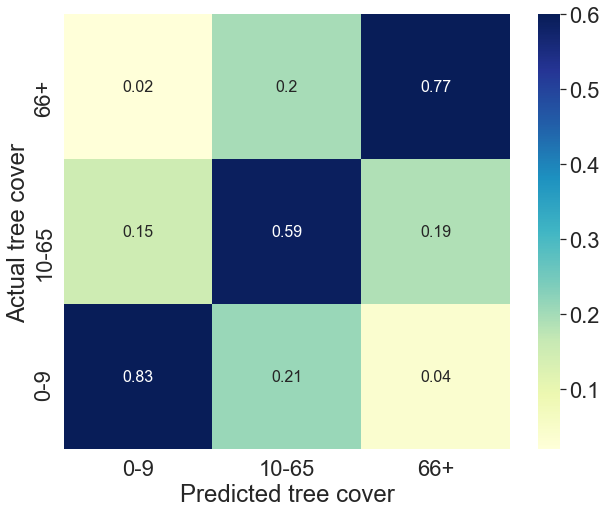

In [863]:
new_y2 = np.zeros_like(new_y)
new_x2 = np.zeros_like(new_x)
for i, (value1, value2) in enumerate(zip(new_x, new_y)):
    if value1 in [0, 0.02, 0.04, 0.06, 0.08]:
        new_x2[i] = 1.
    if value1 in [0.15, 0.25, 0.35, 0.45, 0.55, 0.65]:
        new_x2[i] = 2.
    if value1 in[0.75, 0.85, 0.95]:
        new_x2[i] = 4.
        
    if value2 in [0, 0.02, 0.04, 0.06, 0.08]:
        new_y2[i] = 1.
    if value2 in [0.15, 0.25, 0.35, 0.45, 0.55, 0.65]:
        new_y2[i] = 2.
    if value2 in[0.75,  0.85, 0.95]:
        new_y2[i] = 4.
        
        
from sklearn import metrics
plt.figure(figsize=(10, 8))
sns.set(font_scale = 2)
C = metrics.confusion_matrix(new_y2, new_x2)
C = C / C.astype(np.float).sum(axis=0, keepdims=True) 
C = np.flipud(C)
ax = sns.heatmap(C,
           cmap="YlGnBu", vmax = 0.6, annot=True, annot_kws={"size": 16},
           yticklabels = ["66+", "10-65", "0-9"],
           xticklabels = ["0-9", "10-65", "66+"]
                )
ax.set(xlabel='Predicted tree cover', ylabel='Actual tree cover')
plt.show()

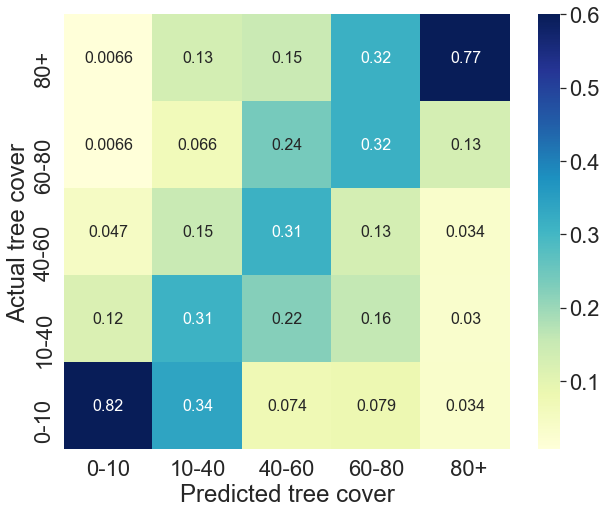

In [864]:
y_rounded = (np.around(np.array(new_y), 1) * 100).astype(int)
x_rounded = (np.around(np.array(new_x), 1) * 100).astype(int)

y_rounded[np.argwhere(y_rounded == 10)] = 20
x_rounded[np.argwhere(x_rounded == 10)] = 20
y_rounded[np.argwhere(y_rounded == 100)] = 80
x_rounded[np.argwhere(x_rounded == 100)] = 80

from sklearn import metrics
plt.figure(figsize=(10, 8))

confusion = metrics.confusion_matrix(y_rounded, x_rounded)
confusion = np.flipud(confusion)
ax = sns.heatmap((confusion / ((np.sum(confusion, axis = 0)))),
           cmap="YlGnBu", vmax = 0.6, annot=True, annot_kws={"size": 16},
                 yticklabels = ['80+', '60-80', '40-60', '10-40', '0-10'],
                 xticklabels = ['0-10', '10-40', '40-60', '60-80',' 80+'],
                )
ax.set(xlabel='Predicted tree cover', ylabel='Actual tree cover')
plt.show()

In [869]:
print("Random Forest")
new_y = np.array(new_y)
new_x = np.array(new_x)
fao_y = np.array(df[df['PLOT_ID'].isin(total_files)]['tree_cover'])
countries = np.array(df[df['PLOT_ID'].isin(total_files)]['Country'])
for i in np.unique(countries):
    country_i_y = new_y[np.argwhere(countries == i)].flatten()
    country_i_x = new_x[np.argwhere(countries == i)].flatten()
    diffs = np.around(np.mean(abs(country_i_y - country_i_x)), 2)
    cor = np.corrcoef(np.array(country_i_y), country_i_x)[0][1]
    ci = r_confidence_interval(cor, 0.05, len(country_i_x))
    cis = [np.around(ci[0], 3), np.around(ci[1], 3)]
    print(i, "\t\t\t",  np.around(cor, 3), "Diffs: ", diffs, "CI", cis, len(country_i_x), cis[1] - cis[0])

Random Forest
Africa 			 0.705 Diffs:  0.2 CI [0.64, 0.759] 280 0.119
Asia 			 0.869 Diffs:  0.11 CI [0.821, 0.905] 136 0.08400000000000007
Australia 			 0.591 Diffs:  0.23 CI [0.446, 0.706] 99 0.25999999999999995
Europe 			 0.755 Diffs:  0.15 CI [0.684, 0.811] 181 0.127
NorthAmerica 			 0.639 Diffs:  0.21 CI [0.538, 0.721] 165 0.18299999999999994
SouthAmerica 			 0.887 Diffs:  0.09 CI [0.846, 0.918] 139 0.07200000000000006


In [870]:
# Random Forestts
fao_y = np.array(df[df['PLOT_ID'].isin(total_files)]['tree_cover'])
aridity = np.array(df[df['PLOT_ID'].isin(total_files)]['Aridity_zone'])
for i in np.unique(aridity):
    country_i_y = new_y[np.argwhere(aridity == i)].flatten()
    country_i_x = new_x[np.argwhere(aridity == i)].flatten()
    print(i, "\t\t\t",  np.corrcoef(np.array(country_i_y), country_i_x)[0][1], len(country_i_x))

Arid 			 0.7056161534108408 70
Dry subhumid 			 0.7408724934733941 442
Hyperarid 			 nan 39
Semiarid 			 0.7214724460209324 449


In [871]:
np.mean(abs(new_x - new_y))

0.16788

In [872]:
forest_pred = np.zeros_like(new_x)
forest_true = np.zeros_like(new_y)
forest_pred[np.argwhere(new_x > 0.1)] = 1.
forest_true[np.argwhere(new_y > 0.1)] = 1.
tp = sum(forest_pred * forest_true)
fp = sum(forest_pred * (1 - forest_true))
fn = sum((1 - forest_pred) * forest_true)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
print(precision, recall)

0.8991735537190083 0.8229954614220878


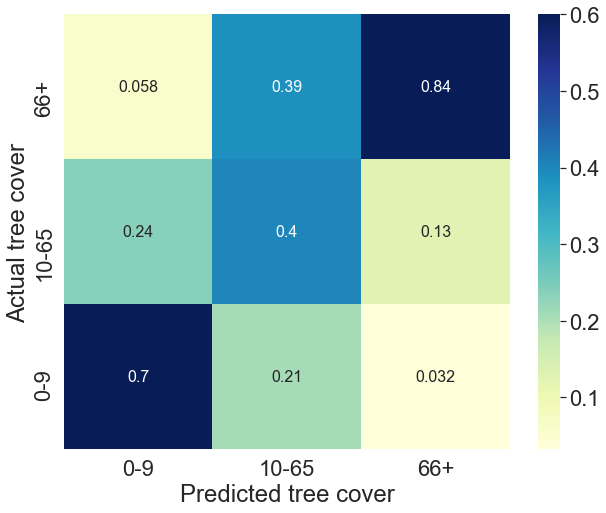

In [873]:
new_y2 = np.zeros_like(new_y)
new_x2 = np.zeros_like(new_x)
for i, (value1, value2) in enumerate(zip(new_x, new_y)):
    if value1 in [0, 0.02, 0.04, 0.06, 0.08]:
        new_x2[i] = 1.
    if value1 in [0.15, 0.25, 0.35, 0.45, 0.55, 0.65]:
        new_x2[i] = 2.
    if value1 in[0.75, 0.85, 0.95]:
        new_x2[i] = 4.
        
    if value2 in [0, 0.02, 0.04, 0.06, 0.08]:
        new_y2[i] = 1.
    if value2 in [0.15, 0.25, 0.35, 0.45, 0.55, 0.65]:
        new_y2[i] = 2.
    if value2 in[0.75,  0.85, 0.95]:
        new_y2[i] = 4.
        
        
from sklearn import metrics
plt.figure(figsize=(10, 8))
sns.set(font_scale = 2)
C = metrics.confusion_matrix(new_y2, new_x2)
C = C / C.astype(np.float).sum(axis=0, keepdims=True) 
C = np.flipud(C)
ax = sns.heatmap(C,
           cmap="YlGnBu", vmax = 0.6, annot=True, annot_kws={"size": 16},
           yticklabels = ["66+", "10-65", "0-9"],
           xticklabels = ["0-9", "10-65", "66+"]
                )
ax.set(xlabel='Predicted tree cover', ylabel='Actual tree cover')
plt.show()

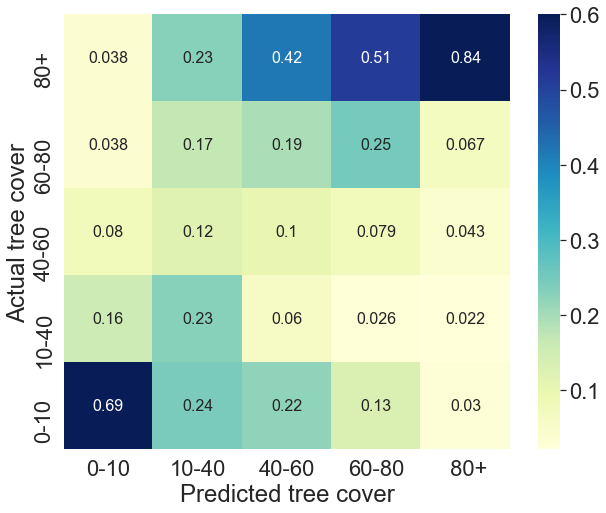

In [874]:
y_rounded = (np.around(np.array(new_y), 1) * 100).astype(int)
x_rounded = (np.around(np.array(new_x), 1) * 100).astype(int)

y_rounded[np.argwhere(y_rounded == 10)] = 20
x_rounded[np.argwhere(x_rounded == 10)] = 20
y_rounded[np.argwhere(y_rounded == 100)] = 80
x_rounded[np.argwhere(x_rounded == 100)] = 80

from sklearn import metrics
plt.figure(figsize=(10, 8))

confusion = metrics.confusion_matrix(y_rounded, x_rounded)
confusion = np.flipud(confusion)
ax = sns.heatmap((confusion / ((np.sum(confusion, axis = 0)))),
           cmap="YlGnBu", vmax = 0.6, annot=True, annot_kws={"size": 16},
                 yticklabels = ['80+', '60-80', '40-60', '10-40', '0-10'],
                 xticklabels = ['0-10', '10-40', '40-60', '60-80',' 80+'],
                )
ax.set(xlabel='Predicted tree cover', ylabel='Actual tree cover')
plt.show()

In [879]:
print("UNET")
new_y = np.array(new_y)
new_x = np.array(new_x)
fao_y = np.array(df[df['PLOT_ID'].isin(total_files)]['tree_cover'])
countries = np.array(df[df['PLOT_ID'].isin(total_files)]['Country'])
for i in np.unique(countries):
    country_i_y = new_y[np.argwhere(countries == i)].flatten()
    country_i_x = new_x[np.argwhere(countries == i)].flatten()
    diffs = np.around(np.mean(abs(country_i_y - country_i_x)), 2)
    cor = np.corrcoef(np.array(country_i_y), country_i_x)[0][1]
    ci = r_confidence_interval(cor, 0.05, len(country_i_x))
    cis = [np.around(ci[0], 3), np.around(ci[1], 3)]
    print(i, "\t\t\t",  np.around(cor, 3), "Diffs: ", diffs, "CI", cis, len(country_i_x), cis[1] - cis[0])

UNET
Africa 			 0.782 Diffs:  0.16 CI [0.732, 0.824] 280 0.09199999999999997
Asia 			 0.813 Diffs:  0.11 CI [0.747, 0.863] 136 0.11599999999999999
Australia 			 0.719 Diffs:  0.21 CI [0.608, 0.803] 99 0.19500000000000006
Europe 			 0.664 Diffs:  0.19 CI [0.574, 0.739] 181 0.16500000000000004
NorthAmerica 			 0.619 Diffs:  0.22 CI [0.515, 0.705] 165 0.18999999999999995
SouthAmerica 			 0.845 Diffs:  0.1 CI [0.789, 0.887] 139 0.09799999999999998


In [880]:
np.mean(abs(new_x - new_y))

0.16423999999999997

In [881]:
forest_pred = np.zeros_like(new_x)
forest_true = np.zeros_like(new_y)
forest_pred[np.argwhere(new_x > 0.1)] = 1.
forest_true[np.argwhere(new_y > 0.1)] = 1.
tp = sum(forest_pred * forest_true)
fp = sum(forest_pred * (1 - forest_true))
fn = sum((1 - forest_pred) * forest_true)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
print(precision, recall)

0.9209225700164745 0.8456883509833586


In [882]:
# UNET
fao_y = np.array(df[df['PLOT_ID'].isin(total_files)]['tree_cover'])
aridity = np.array(df[df['PLOT_ID'].isin(total_files)]['Aridity_zone'])
for i in np.unique(aridity):
    country_i_y = new_y[np.argwhere(aridity == i)].flatten()
    country_i_x = new_x[np.argwhere(aridity == i)].flatten()
    print(i, "\t\t\t",  np.corrcoef(np.array(country_i_y), country_i_x)[0][1], len(country_i_x))

Arid 			 0.6698463582847652 70
Dry subhumid 			 0.7492087115665559 442
Hyperarid 			 nan 39
Semiarid 			 0.7209543982310558 449


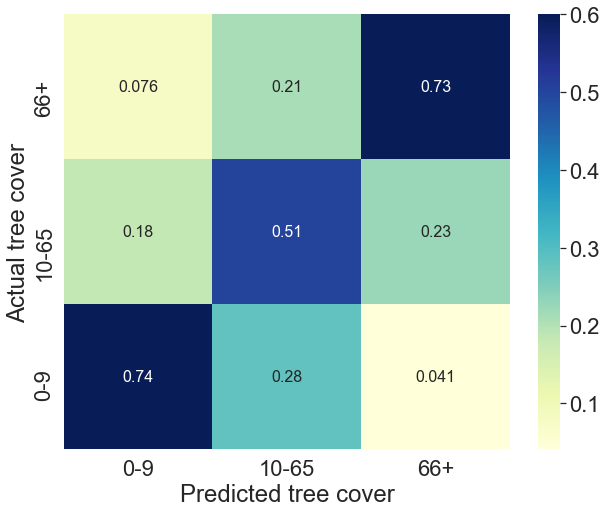

In [883]:
new_y2 = np.zeros_like(new_y)
new_x2 = np.zeros_like(new_x)
for i, (value1, value2) in enumerate(zip(new_x, new_y)):
    if value1 in [0, 0.02, 0.04, 0.06, 0.08]:
        new_x2[i] = 1.
    if value1 in [0.15, 0.25, 0.35, 0.45, 0.55, 0.65]:
        new_x2[i] = 2.
    if value1 in[0.75, 0.85, 0.95]:
        new_x2[i] = 4.
        
    if value2 in [0, 0.02, 0.04, 0.06, 0.08]:
        new_y2[i] = 1.
    if value2 in [0.15, 0.25, 0.35, 0.45, 0.55, 0.65]:
        new_y2[i] = 2.
    if value2 in[0.75,  0.85, 0.95]:
        new_y2[i] = 4.
        
        
from sklearn import metrics
plt.figure(figsize=(10, 8))
sns.set(font_scale = 2)
C = metrics.confusion_matrix(new_y2, new_x2)
C = C / C.astype(np.float).sum(axis=0, keepdims=True) 
C = np.flipud(C)
ax = sns.heatmap(C,
           cmap="YlGnBu", vmax = 0.6, annot=True, annot_kws={"size": 16},
           yticklabels = ["66+", "10-65", "0-9"],
           xticklabels = ["0-9", "10-65", "66+"]
                )
ax.set(xlabel='Predicted tree cover', ylabel='Actual tree cover')
plt.show()

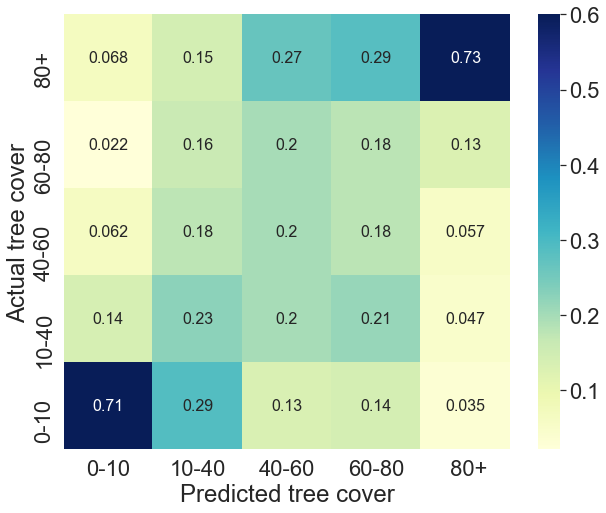

In [884]:
y_rounded = (np.around(np.array(new_y), 1) * 100).astype(int)
x_rounded = (np.around(np.array(new_x), 1) * 100).astype(int)

y_rounded[np.argwhere(y_rounded == 10)] = 20
x_rounded[np.argwhere(x_rounded == 10)] = 20
y_rounded[np.argwhere(y_rounded == 100)] = 80
x_rounded[np.argwhere(x_rounded == 100)] = 80

from sklearn import metrics
plt.figure(figsize=(10, 8))

confusion = metrics.confusion_matrix(y_rounded, x_rounded)
confusion = np.flipud(confusion)
ax = sns.heatmap((confusion / ((np.sum(confusion, axis = 0)))),
           cmap="YlGnBu", vmax = 0.6, annot=True, annot_kws={"size": 16},
                 yticklabels = ['80+', '60-80', '40-60', '10-40', '0-10'],
                 xticklabels = ['0-10', '10-40', '40-60', '60-80',' 80+'],
                )
ax.set(xlabel='Predicted tree cover', ylabel='Actual tree cover')
plt.show()

In [183]:
print("This is the correlation between the labeled CEO plots and the labeled FAO plots")
np.corrcoef(np.array(new_y) / 49, fao_y)[0][1]

This is the correlation between the labeled CEO plots and the labeled FAO plots


0.6200920045710808

In [184]:
print("This is the correlation between the plot predictions and the labeled FAO plots")
np.corrcoef(np.array(total_x), fao_y)

This is the correlation between the plot predictions and the labeled FAO plots


array([[1.        , 0.54687917],
       [0.54687917, 1.        ]])

In [185]:
len(np.argwhere((total_y / 49 - fao_y) < 0.3)) / len(total_y)

0.784